<a href="https://colab.research.google.com/github/freha-mezzoudj/NLP/blob/main/SentimentAnalysis_Airlines_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from pandas import read_excel
import numpy as np
#!pip install re
!pip install unidecode
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 9.3 MB/s 


In [ ]:
def text_to_word_list(text):
    text = text.split()
    return text

def replace_strings(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\u00C0-\u017F"          #latin
                           u"\u2000-\u206F"          #generalPunctuations
                               
                           "]+", flags=re.UNICODE)
    english_pattern=re.compile('[a-zA-Z0-9]+', flags=re.I)
    #latin_pattern=re.compile('[A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]*',)
    
    text=emoji_pattern.sub(r'', text)
    text=english_pattern.sub(r'', text)

    return text

def remove_punctuations(my_str):
    # define punctuation
    punctuations = '''````£|¢|Ñ+-*/=EROero৳০১২৩৪৫৬৭৮৯012–34567•89।!()-[]{};:'"“\’,<>./?@#$%^&*_~‘—॥”‰⚽️✌�￰৷￰'''
    
    no_punct = ""
    for char in my_str:
        if char not in punctuations:
            no_punct = no_punct + char

    # display the unpunctuated string
    return no_punct



def joining(text):
    out=' '.join(text)
    return out

def preprocessing(text):
    out=remove_punctuations(replace_strings(text))
    return out

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/data")
!ls

 cnn_lstm.h5  'Copie de reviews.txt'   reviews.txt
 cnnlstm.h5    labels.txt	       Tweets2.csv


In [ ]:
#Airline tweets download from kaggle and saved on my google drive!
df=pd.read_csv('Tweets2.csv')
df = df[["airline_sentiment","text"]]
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [ ]:
#neutral-->2   #positive-->1   #negative-->0
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="neutral", value=2)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="positive", value=1)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="negative", value=0)
df


,airline_sentiment,text
0,2,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,2,@VirginAmerica I didn't today... Must mean I n...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,1,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...
14637,2,@AmericanAir Please bring American Airlines to...
14638,0,"@AmericanAir you have my money, you change my ..."


In [ ]:
#We droped neutral (2) stweets to deal with binary classification (negative and positive)!
#from 14640 tweets, we will use only 11541 ones! 

df.drop(df.index[df['airline_sentiment'] == 2], inplace=True)
df


,airline_sentiment,text
1,1,@VirginAmerica plus you've added commercials t...
3,0,@VirginAmerica it's really aggressive to blast...
4,0,@VirginAmerica and it's a really big bad thing...
5,0,@VirginAmerica seriously would pay $30 a fligh...
6,1,"@VirginAmerica yes, nearly every time I fly VX..."
...,...,...
14633,0,@AmericanAir my flight was Cancelled Flightled...
14634,0,@AmericanAir right on cue with the delays👌
14635,1,@AmericanAir thank you we got on a different f...
14636,0,@AmericanAir leaving over 20 minutes Late Flig...


In [ ]:
#airline database with only 2 columns!
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11541 entries, 1 to 14638
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  11541 non-null  object
 1   text               11541 non-null  object
dtypes: object(2)
memory usage: 528.5+ KB


In [ ]:
df.count()

airline_sentiment    11541
text                 11541
dtype: int64

In [ ]:
df.dtypes

airline_sentiment    object
text                 object
dtype: object

In [ ]:
temp = df.groupby('airline_sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')
#Reason is useful for inballenced data but we don't use it in this example!

,airline_sentiment,text
0,0,9178
1,1,2363


In [ ]:
#split data: training set (tweets + labels) and test set (tweets + labels)!
train1, test1 = train_test_split(df, test_size=0.2, random_state=69)  
training_sentences = []
testing_sentences = []

#X_train, X_test, y_train, y_test = train_test_split(
#...     X, y, test_size=0.33, random_state=42)

train_sentences=train1['text'].values
train_labels=train1['airline_sentiment'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)

test_sentences=test1['text'].values
test_labels=test1['airline_sentiment'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)

train_labels=keras.utils.np_utils.to_categorical(train_labels)

test_labels=keras.utils.np_utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 9232
Testing Set Length: 2309
training_sentences shape: (9232,)
testing_sentences shape: (2309,)
train_labels shape: (9232, 2)
test_labels shape: (2309, 2)


In [ ]:
print(training_sentences[6])
print(train_labels[0])


@USAirways is the worst. 45 minute delay in Boston. Not weather reLate Flightd. Going to miss our connecting flight. Gassing up the plane issue.
[1. 0.]


In [ ]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

11600
Word index length:11600


In [ ]:
print("Sentence :--> \n")
print(training_sentences[6]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[6])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[6])

Sentence :--> 

@USAirways is the worst. 45 minute delay in Boston. Not weather reLate Flightd. Going to miss our connecting flight. Gassing up the plane issue.

Sentence Tokenized and Converted into Sequence :--> 

[13, 15, 3, 149, 361, 523, 122, 16, 435, 23, 146, 1167, 934, 127, 2, 225, 69, 393, 9, 5020, 51, 3, 60, 238]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   13   15    3  149  361  523  122   16
  435   23  146 1167  934  127    2  225   69  393    9 5020   51    3
   60  238]


**Padding**                                                  
The neural networks require to have inputs that have the same size and shape. In NLP application (e.g. Sentiment Analysis), it is recommended to use the texts (tweets or sentences with the same length) as inputs for our model such as LSTM.  Based on the fact that some of the sentences are longer or shorter, it is necessary to apply the padding on our textual data.

In [ ]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (9232, 100)
Padded shape(testing): (2309, 100)


**LSTM **

The Long Short-Term Memory (LSTM) cell was proposed in 19977 by Sepp Hochreiter
and Jürgen Schmidhuber and gradually improved by other researchers,e. g. Alex Graves, Haşim Sak,8 and Wojciech Zaremba.

In [ ]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(200, kernel_size=3, activation = "relu"))
    #model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(2, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 300)          7500000   
                                                                 
 conv1d_4 (Conv1D)           (None, 98, 200)           180200    
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              135680    
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 50)                6450      
                                                                 
 dense_17 (Dense)            (None, 50)                2550      
                                                                 
 flatten_4 (Flatten)         (None, 50)                0         
                                                      

In [ ]:
    history=model.fit(padded,train_labels,epochs=5,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
37/37 [==============================] - 67s 1s/step - loss: 1.1172 - accuracy: 0.7919 - val_loss: 0.9048 - val_accuracy: 0.8289
Epoch 2/5
37/37 [==============================] - 48s 1s/step - loss: 0.7603 - accuracy: 0.8760 - val_loss: 0.6278 - val_accuracy: 0.9117
Epoch 3/5
37/37 [==============================] - 52s 1s/step - loss: 0.4913 - accuracy: 0.9523 - val_loss: 0.5194 - val_accuracy: 0.9311
Epoch 4/5
37/37 [==============================] - 48s 1s/step - loss: 0.3644 - accuracy: 0.9699 - val_loss: 0.4471 - val_accuracy: 0.9264
Epoch 5/5
37/37 [==============================] - 51s 1s/step - loss: 0.2594 - accuracy: 0.9872 - val_loss: 0.4314 - val_accuracy: 0.9190


**Accuracy**

The validation accuracy is computed from a subset taken from the test dataset that is separate from the training set. We use a validation set to tune the model's hyperparmaters and then to measure the ability of the model to generalize on unseen data. 

When the validation accuracy is greater than the training accuracy. There is a high chance that the model is overfitted. You can improve the model by reducing the bias and variance.

The validation accuracy can be lower (then 85% for example)for multiple reasons -may be for imbalanced classes, overfitting, not enough data if there is a large discrepancy between the training set.

In [ ]:
import matplotlib.pyplot as plt

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


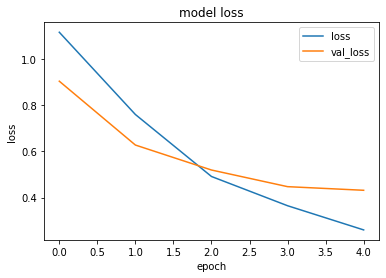

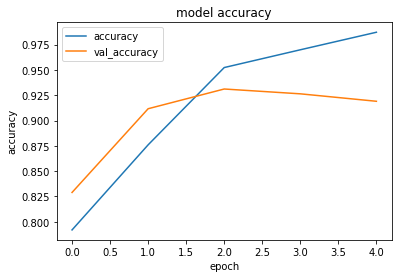

In [ ]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

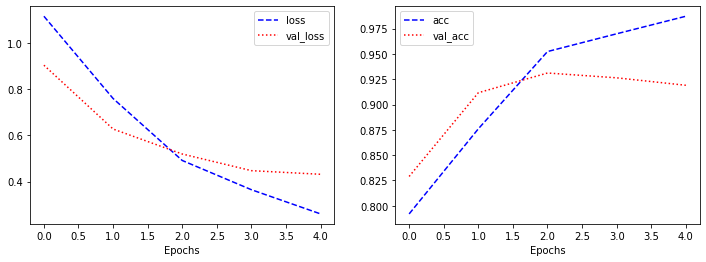

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [ ]:
model.save('cnnlstm.h5')

In [ ]:
from keras.models import load_model

In [ ]:
model = keras.models.load_model('cnnlstm.h5')

In [ ]:
test_sentence1 = ["big bad thing and horrible idea"]

#Converting the sentences to sequences using a tokenizer
test_sequences1 = tokenizer.texts_to_sequences(test_sentence1)

#Padding the new sequences to make them have the same dimension
test_padded1 = pad_sequences(test_sequences1, maxlen = 25000, 
                             padding = 'post')

#Testing out the new padded data on a trained CNN-LSTM model
test_padded1 = np.array(test_padded1)
print(model.predict(test_padded1))